In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
import os
from tqdm import tqdm_notebook
from time import ctime

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models

In [56]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# setting directories
ROOT_DIR = os.path.abspath('data/')
TRAIN_JPEG_DIR = os.path.join(ROOT_DIR, 'train-jpg')
TEST_JPEG_DIR = os.path.join(ROOT_DIR, 'test-jpg')
TRAIN_TIF_DIR = os.path.join(ROOT_DIR, 'train-tif-v2')
TEST_TIF_DIR = os.path.join(ROOT_DIR, 'test-tif-v3')

In [4]:
def read_image(path):
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]

In [6]:
training_images = os.listdir(TRAIN_JPEG_DIR)
print(training_images[0])

train_11047.jpg


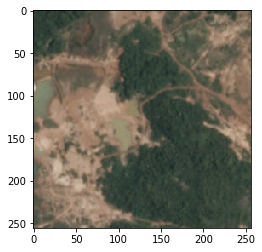

In [7]:
sample_path = os.path.join(TRAIN_JPEG_DIR, 'train_9203.jpg')
im = read_image(sample_path)
plt.imshow(im)

In [8]:
# typical size: 256x256 so should be able to train directly without resizing
dims = [read_image(os.path.join(TRAIN_JPEG_DIR, p)).shape for p in training_images[:50]]
dims[:10]

[(256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3)]

### Data splitting

In [9]:
train_file_names = list(os.listdir(TRAIN_JPEG_DIR))
train_labels_df = pd.read_csv(os.path.join(ROOT_DIR, 'train_v2.csv'))
test_file_names = list(os.listdir(TEST_JPEG_DIR))

In [10]:
train_IDs = [f.split('.')[0] for f in train_file_names]
test_IDs = [f.split('.')[0] for f in test_file_names]

In [11]:
inner_train_IDs, val_IDs = train_test_split(train_IDs, test_size=0.2, random_state=42)

In [12]:
partition = {'train': train_IDs, 'inner_train': inner_train_IDs, 
             'validation': val_IDs, 'test': test_IDs}

In [13]:
train_labels = []
for tag in train_labels_df.tags:
    train_labels.append(tag.split())

In [14]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)

In [15]:
labels = {}
for i, row in enumerate(train_labels_df.itertuples()):
    labels[row.image_name] = train_labels[i]

### Data Augmentation

In [16]:
def crop(im, r, c, target_r, target_c):
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """Returns a random crop"""
    r, c, *_ = x.shape
    r, c, *_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c/2, r/2), deg, 1)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Dataset

In [17]:
class PlanetDataset(Dataset):
    def __init__(self, folder_path, list_IDs, labels, transforms=False):
        self.list_IDs = list_IDs
        self.labels = labels
        self.folder_path = folder_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, idx):
        name = self.list_IDs[idx]
        file_path = os.path.join(self.folder_path, name + '.jpg')
        x = cv2.imread(file_path).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        if self.transforms:
            rdeg = (np.random.random() - 0.50) * 20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5:
                x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        if self.labels is not None:
            y = self.labels[name]
            return np.rollaxis(x, 2), y
        return np.rollaxis(x, 2)

In [18]:
inner_train_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['inner_train'], labels, True)
val_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels)

In [19]:
batch_size = 64
inner_train_dl = DataLoader(inner_train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size) 

In [20]:
x, y = inner_train_ds[0]

In [21]:
print(x.shape, y.shape)

(3, 240, 240) (17,)


In [22]:
x, y = iter(inner_train_dl).next()

In [23]:
print(x.shape, y.shape)

torch.Size([64, 3, 240, 240]) torch.Size([64, 17])


### Models

In [37]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 17)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1) # Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

In [71]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        # separate conv layers into two groups
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        # add a linear layer as the classifier
        self.groups.append(nn.Linear(512, num_classes))
    
    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x)
        return x

    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [72]:
net = Resnet34(num_classes=17).cuda()

In [73]:
x, y = iter(inner_train_dl).next()
x = x.cuda().float()
y = y.cuda().float()

In [74]:
output = net(x)

In [75]:
output_sigmoid = F.sigmoid(output)

In [76]:
output_sigmoid.cpu().detach().numpy()

array([[0.5400335 , 0.553316  , 0.66885555, ..., 0.5865437 , 0.42770407,
        0.41796073],
       [0.58796775, 0.41731682, 0.73766404, ..., 0.45787287, 0.25645044,
        0.5407444 ],
       [0.50135654, 0.4507148 , 0.7342699 , ..., 0.49241683, 0.54124063,
        0.5509023 ],
       ...,
       [0.6019346 , 0.44358537, 0.55459285, ..., 0.49452955, 0.24717194,
        0.7301337 ],
       [0.6054467 , 0.6007379 , 0.80439365, ..., 0.5167569 , 0.39285707,
        0.5365321 ],
       [0.5848502 , 0.5452216 , 0.65376806, ..., 0.55905354, 0.4518962 ,
        0.53853744]], dtype=float32)

In [64]:
fbeta_score(y.cpu(), output_sigmoid.cpu() > 0.5, beta=2, average='samples')

0.45582665181505555

In [65]:
y

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [66]:
F.binary_cross_entropy_with_logits(y, output)

tensor(0.7720, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### Learning Rate Functions and Schedulers

In [112]:
def lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print("Setting base LR to %.8f" % lr)
    return lr

In [ ]:
def lr_scheduler(optimizer, epoch, init_lr=0.01, group_lrs, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        logger.info('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [97]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)]
    params = [{'params': p, 'lr': lr} for p, lr in zip(param_groups, [lr0/9, lr0/3, lr0] )]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [77]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

### Utility functions

In [86]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

### Train model

In [45]:
def validate(model, val_dl):
    model.eval()
    total_loss = 0
    sum_f2 = 0
    true_labels = []
    predictions = []
    with torch.no_grad():
        for data, target in tqdm_notebook(val_dl, desc='Validation metrics', total=len(val_dl)):
            true_labels.append(target.cpu().numpy())
            data, target = data.cuda().float(), target.cuda().float()
            
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
            total_loss += F.binary_cross_entropy_with_logits(pred, target).item()
            
        avg_loss = total_loss / len(val_dl)
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        f2_score = fbeta_score(true_labels, predictions > 0.5, beta=2, average='samples')
        return f2_score, avg_loss

In [69]:
validate(net, val_dl)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.4811865313176601, 0.6606815710781128)

In [53]:
# training loop for one epoch
def train(epoch, model, optimizer, train_dl):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.cuda().float(), target.cuda().float()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch %d (Batch %d / %d)\t Train loss: %.3f" % (epoch+1, batch_idx, len(train_dl), loss.item()))

In [ ]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
#     lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            if idx == int(0.2*iterations):
                model.unfreeze(0)
                print(idx, "unfreezing 0")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.9:
                path = "{0}/models/model_resnet34_loss_{1:.0f}.pth".format(PATH, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [57]:
# model
model = Resnet(num_classes=17).cuda()
# datasets
inner_train_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['inner_train'], labels, True)
val_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels)
# data loaders
batch_size = 64
inner_train_dl = DataLoader(inner_train_ds,
                            batch_size=batch_size,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=batch_size,
                    num_workers=4,
                    pin_memory=True)
# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# training loop
epochs = 10
for epoch in range(epochs):
    print(ctime())
    train(epoch, model, optimizer, inner_train_dl)
    val_f2_score, val_loss = validate(model, val_dl)
    print("Epoch %d \t Validation loss: %.3f, F2 score: %.3f" % (epoch+1, val_loss, val_f2_score))

Sun Jun 23 22:54:17 2019
Epoch 0 (Batch 0 / 506)	 Train loss: 0.774
Epoch 0 (Batch 100 / 506)	 Train loss: 0.165
Epoch 0 (Batch 200 / 506)	 Train loss: 0.151
Epoch 0 (Batch 300 / 506)	 Train loss: 0.171
Epoch 0 (Batch 400 / 506)	 Train loss: 0.194
Epoch 0 (Batch 500 / 506)	 Train loss: 0.142


Epoch 0 	 Validation loss: 0.135, F2 score: 0.847
Sun Jun 23 22:56:09 2019
Epoch 1 (Batch 0 / 506)	 Train loss: 0.142
Epoch 1 (Batch 100 / 506)	 Train loss: 0.153
Epoch 1 (Batch 200 / 506)	 Train loss: 0.143
Epoch 1 (Batch 300 / 506)	 Train loss: 0.158
Epoch 1 (Batch 400 / 506)	 Train loss: 0.172
Epoch 1 (Batch 500 / 506)	 Train loss: 0.153


Epoch 1 	 Validation loss: 0.160, F2 score: 0.851
Sun Jun 23 22:57:59 2019
Epoch 2 (Batch 0 / 506)	 Train loss: 0.140
Epoch 2 (Batch 100 / 506)	 Train loss: 0.111
Epoch 2 (Batch 200 / 506)	 Train loss: 0.143
Epoch 2 (Batch 300 / 506)	 Train loss: 0.138
Epoch 2 (Batch 400 / 506)	 Train loss: 0.178
Epoch 2 (Batch 500 / 506)	 Train loss: 0.170


Epoch 2 	 Validation loss: 0.160, F2 score: 0.851
Sun Jun 23 22:59:49 2019
Epoch 3 (Batch 0 / 506)	 Train loss: 0.125
Epoch 3 (Batch 100 / 506)	 Train loss: 0.173
Epoch 3 (Batch 200 / 506)	 Train loss: 0.169
Epoch 3 (Batch 300 / 506)	 Train loss: 0.138
Epoch 3 (Batch 400 / 506)	 Train loss: 0.165
Epoch 3 (Batch 500 / 506)	 Train loss: 0.173


Epoch 3 	 Validation loss: 0.143, F2 score: 0.851
Sun Jun 23 23:01:40 2019
Epoch 4 (Batch 0 / 506)	 Train loss: 0.164
Epoch 4 (Batch 100 / 506)	 Train loss: 0.145
Epoch 4 (Batch 200 / 506)	 Train loss: 0.124
Epoch 4 (Batch 300 / 506)	 Train loss: 0.152
Epoch 4 (Batch 400 / 506)	 Train loss: 0.141
Epoch 4 (Batch 500 / 506)	 Train loss: 0.112


Epoch 4 	 Validation loss: 0.147, F2 score: 0.848
Sun Jun 23 23:03:30 2019
Epoch 5 (Batch 0 / 506)	 Train loss: 0.168
Epoch 5 (Batch 100 / 506)	 Train loss: 0.202
Epoch 5 (Batch 200 / 506)	 Train loss: 0.155
Epoch 5 (Batch 300 / 506)	 Train loss: 0.159
Epoch 5 (Batch 400 / 506)	 Train loss: 0.122
Epoch 5 (Batch 500 / 506)	 Train loss: 0.126


Epoch 5 	 Validation loss: 0.158, F2 score: 0.825
Sun Jun 23 23:05:20 2019
Epoch 6 (Batch 0 / 506)	 Train loss: 0.160
Epoch 6 (Batch 100 / 506)	 Train loss: 0.147
Epoch 6 (Batch 200 / 506)	 Train loss: 0.202
Epoch 6 (Batch 300 / 506)	 Train loss: 0.101
Epoch 6 (Batch 400 / 506)	 Train loss: 0.127
Epoch 6 (Batch 500 / 506)	 Train loss: 0.116


Epoch 6 	 Validation loss: 0.159, F2 score: 0.831
Sun Jun 23 23:07:11 2019
Epoch 7 (Batch 0 / 506)	 Train loss: 0.163
Epoch 7 (Batch 100 / 506)	 Train loss: 0.129
Epoch 7 (Batch 200 / 506)	 Train loss: 0.198
Epoch 7 (Batch 300 / 506)	 Train loss: 0.185
Epoch 7 (Batch 400 / 506)	 Train loss: 0.166
Epoch 7 (Batch 500 / 506)	 Train loss: 0.174


Epoch 7 	 Validation loss: 0.159, F2 score: 0.830
Sun Jun 23 23:09:01 2019
Epoch 8 (Batch 0 / 506)	 Train loss: 0.133
Epoch 8 (Batch 100 / 506)	 Train loss: 0.136
Epoch 8 (Batch 200 / 506)	 Train loss: 0.173
Epoch 8 (Batch 300 / 506)	 Train loss: 0.128
Epoch 8 (Batch 400 / 506)	 Train loss: 0.126
Epoch 8 (Batch 500 / 506)	 Train loss: 0.139


Epoch 8 	 Validation loss: 0.152, F2 score: 0.840
Sun Jun 23 23:10:51 2019
Epoch 9 (Batch 0 / 506)	 Train loss: 0.140
Epoch 9 (Batch 100 / 506)	 Train loss: 0.125
Epoch 9 (Batch 200 / 506)	 Train loss: 0.125
Epoch 9 (Batch 300 / 506)	 Train loss: 0.177
Epoch 9 (Batch 400 / 506)	 Train loss: 0.137
Epoch 9 (Batch 500 / 506)	 Train loss: 0.156


Epoch 9 	 Validation loss: 0.144, F2 score: 0.848


In [ ]:
# training loop for one epoch
def train(epoch, lrs, model, optimizer, train_dl):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.cuda().float(), target.cuda().float()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx 
        if batch_idx % 100 == 0:
            print("Epoch %d (Batch %d / %d)\t Train loss: %.3f" % (epoch+1, batch_idx, len(train_dl), loss.item()))

In [93]:
# model
model = Resnet34(num_classes=17).cuda()
# datasets
train_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['inner_train'], labels, True)
val_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels)
# data loaders
batch_size = 64
train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      num_workers=4,
                      pin_memory=True,
                      shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=batch_size,
                    num_workers=4,
                    pin_memory=True)
# lr scheduler
max_lr = 0.04
iterations = epochs*len(train_dl)
lrs = get_cosine_triangular_lr(max_lr, iterations) # create cosine learning rate
optimizer = create_optimizer(model, lrs[0])


# training loop
best_score = 0.0
epochs = 10
idx = 0
for epoch in range(epochs):
    print(ctime())
    for batch_idx, (data, target) in enumerate(train_dl):
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        data, target = data.cuda().float(), target.cuda().float()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        if idx == int(0.1*iterations):
            model.unfreeze(1)
            print(idx, "Unfreezing group 1")
        if idx == int(0.2*iterations):
            model.unfreeze(0)
            print(idx, "Unfreezing group 0")
        if batch_idx % 100 == 0:
            print("Epoch %d (Batch %d / %d)\t Train loss: %.3f" % (epoch+1, batch_idx, len(train_dl), loss.item()))
    val_f2_score, val_loss = validate(model, val_dl)
    print("Epoch %d \t Validation loss: %.3f, F2 score: %.3f" % (epoch+1, val_loss, val_f2_score))
    if val_f2_score > best_score:
        best_score = val_f2_score
        file_path = os.path.join('models', 'model_resnet34_%d.pth' % (100*val_f2_score))
        print("Saving model to %s" % file_path)
        save_model(model, file_path)

Mon Jun 24 01:24:05 2019
Epoch 1 (Batch 0 / 506)	 Train loss: 0.785
Epoch 1 (Batch 100 / 506)	 Train loss: 0.195
Epoch 1 (Batch 200 / 506)	 Train loss: 0.181
Epoch 1 (Batch 300 / 506)	 Train loss: 0.151
Epoch 1 (Batch 400 / 506)	 Train loss: 0.147
Epoch 1 (Batch 500 / 506)	 Train loss: 0.159
506 Unfreezing group 1


Epoch 1 	 Validation loss: 0.151, F2 score: 0.833
Saving model to models/model_resnet34_83.pth
Mon Jun 24 01:25:55 2019
Epoch 2 (Batch 0 / 506)	 Train loss: 0.138
Epoch 2 (Batch 100 / 506)	 Train loss: 69.264
Epoch 2 (Batch 200 / 506)	 Train loss: 2.383
Epoch 2 (Batch 300 / 506)	 Train loss: 0.277
Epoch 2 (Batch 400 / 506)	 Train loss: 0.244
Epoch 2 (Batch 500 / 506)	 Train loss: 0.268
1012 Unfreezing group 0


Epoch 2 	 Validation loss: 0.258, F2 score: 0.639
Mon Jun 24 01:28:41 2019
Epoch 3 (Batch 0 / 506)	 Train loss: 0.231
Epoch 3 (Batch 100 / 506)	 Train loss: 0.282
Epoch 3 (Batch 200 / 506)	 Train loss: 0.239
Epoch 3 (Batch 300 / 506)	 Train loss: 3006500864.000
Epoch 3 (Batch 400 / 506)	 Train loss: 308007043072.000
Epoch 3 (Batch 500 / 506)	 Train loss: 17.006


Epoch 3 	 Validation loss: 14.432, F2 score: 0.575
Mon Jun 24 01:33:15 2019
Epoch 4 (Batch 0 / 506)	 Train loss: 15.186
Epoch 4 (Batch 100 / 506)	 Train loss: 5.179


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/h

KeyboardInterrupt: 

In [ ]:
# model
model = Resnet34(num_classes=17).cuda()
# datasets
train_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['inner_train'], labels, True)
val_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels)
# data loaders
batch_size = 64
train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      num_workers=4,
                      pin_memory=True,
                      shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=batch_size,
                    num_workers=4,
                    pin_memory=True)
# lr scheduler
init_lr = 0.01
iterations = epochs*len(train_dl)

# training loop
best_score = 0.0
epochs = 40
idx = 0
for epoch in range(epochs):
    print(ctime())
    lr = lr_scheduler(optimizer, epoch, init_lr, 7)
    optimizer = create_optimizer(model, lr)
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.cuda().float(), target.cuda().float()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        if idx == int(0.1*iterations):
            model.unfreeze(1)
            print("Iteration %d: Unfreezing group 1" % idx)
        if idx == int(0.2*iterations):
            model.unfreeze(0)
            print("Iteration %d: Unfreezing group 0" % idx)
        if batch_idx % 100 == 0:
            print("Epoch %d (Batch %d / %d)\t Train loss: %.3f" % (epoch+1, batch_idx, len(train_dl), loss.item()))
    val_f2_score, val_loss = validate(model, val_dl)
    print("Epoch %d \t Validation loss: %.3f, F2 score: %.3f" % (epoch+1, val_loss, val_f2_score))
    if val_f2_score > best_score:
        best_score = val_f2_score
        file_path = os.path.join('models', 'model_resnet34_%d.pth' % (100*val_f2_score))
        print("Saving model to %s" % file_path)
        save_model(model, file_path)

Mon Jun 24 02:10:57 2019
Setting base LR to 0.01000000
Epoch 1 (Batch 0 / 506)	 Train loss: 0.726
Epoch 1 (Batch 100 / 506)	 Train loss: 0.159
Epoch 1 (Batch 200 / 506)	 Train loss: 0.142
Epoch 1 (Batch 300 / 506)	 Train loss: 0.162
Epoch 1 (Batch 400 / 506)	 Train loss: 0.206
Epoch 1 (Batch 500 / 506)	 Train loss: 0.163


Epoch 1 	 Validation loss: 0.151, F2 score: 0.836
Saving model to models/model_resnet34_83.pth
Mon Jun 24 02:12:47 2019
Epoch 2 (Batch 0 / 506)	 Train loss: 0.164
Epoch 2 (Batch 100 / 506)	 Train loss: 0.163
Epoch 2 (Batch 200 / 506)	 Train loss: 0.163
Epoch 2 (Batch 300 / 506)	 Train loss: 0.146
Epoch 2 (Batch 400 / 506)	 Train loss: 0.135
Epoch 2 (Batch 500 / 506)	 Train loss: 0.156
Iteration 1012: Unfreezing group 1


Epoch 2 	 Validation loss: 0.149, F2 score: 0.843
Saving model to models/model_resnet34_84.pth
Mon Jun 24 02:14:33 2019
Epoch 3 (Batch 0 / 506)	 Train loss: 0.125
Epoch 3 (Batch 100 / 506)	 Train loss: 0.263
Epoch 3 (Batch 200 / 506)	 Train loss: 0.258
Epoch 3 (Batch 300 / 506)	 Train loss: 0.235
Epoch 3 (Batch 400 / 506)	 Train loss: 0.229
Epoch 3 (Batch 500 / 506)	 Train loss: 0.246


Epoch 3 	 Validation loss: 0.262, F2 score: 0.606
Mon Jun 24 02:17:18 2019
Epoch 4 (Batch 0 / 506)	 Train loss: 0.286
Epoch 4 (Batch 100 / 506)	 Train loss: 0.252
Epoch 4 (Batch 200 / 506)	 Train loss: 0.254
Epoch 4 (Batch 300 / 506)	 Train loss: 0.262
Epoch 4 (Batch 400 / 506)	 Train loss: 0.270
Epoch 4 (Batch 500 / 506)	 Train loss: 0.256
Iteration 2024: Unfreezing group 0


Epoch 4 	 Validation loss: 0.258, F2 score: 0.639
Mon Jun 24 02:20:04 2019
Epoch 5 (Batch 0 / 506)	 Train loss: 0.265
Epoch 5 (Batch 100 / 506)	 Train loss: 0.347
Epoch 5 (Batch 200 / 506)	 Train loss: 0.283
Epoch 5 (Batch 300 / 506)	 Train loss: 0.244
Epoch 5 (Batch 400 / 506)	 Train loss: 0.252
Epoch 5 (Batch 500 / 506)	 Train loss: 0.268


Epoch 5 	 Validation loss: 0.259, F2 score: 0.639
Mon Jun 24 02:24:36 2019
Epoch 6 (Batch 0 / 506)	 Train loss: 0.272
Epoch 6 (Batch 100 / 506)	 Train loss: 0.213
Epoch 6 (Batch 200 / 506)	 Train loss: 0.276
Epoch 6 (Batch 300 / 506)	 Train loss: 0.258
Epoch 6 (Batch 400 / 506)	 Train loss: 0.349
Epoch 6 (Batch 500 / 506)	 Train loss: 0.278


Epoch 6 	 Validation loss: 0.258, F2 score: 0.639
Mon Jun 24 02:29:08 2019
Epoch 7 (Batch 0 / 506)	 Train loss: 0.225
Epoch 7 (Batch 100 / 506)	 Train loss: 0.287
Epoch 7 (Batch 200 / 506)	 Train loss: 0.234
Epoch 7 (Batch 300 / 506)	 Train loss: 0.258
Epoch 7 (Batch 400 / 506)	 Train loss: 0.254
Epoch 7 (Batch 500 / 506)	 Train loss: 0.239


Epoch 7 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:33:40 2019
Setting base LR to 0.00100000
Epoch 8 (Batch 0 / 506)	 Train loss: 0.289
Epoch 8 (Batch 100 / 506)	 Train loss: 0.225
Epoch 8 (Batch 200 / 506)	 Train loss: 0.234
Epoch 8 (Batch 300 / 506)	 Train loss: 0.258
Epoch 8 (Batch 400 / 506)	 Train loss: 0.252
Epoch 8 (Batch 500 / 506)	 Train loss: 0.273


Epoch 8 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:38:11 2019
Epoch 9 (Batch 0 / 506)	 Train loss: 0.277
Epoch 9 (Batch 100 / 506)	 Train loss: 0.256
Epoch 9 (Batch 200 / 506)	 Train loss: 0.264
Epoch 9 (Batch 300 / 506)	 Train loss: 0.271
Epoch 9 (Batch 400 / 506)	 Train loss: 0.249
Epoch 9 (Batch 500 / 506)	 Train loss: 0.235


Epoch 9 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:42:43 2019
Epoch 10 (Batch 0 / 506)	 Train loss: 0.263
Epoch 10 (Batch 100 / 506)	 Train loss: 0.248
Epoch 10 (Batch 200 / 506)	 Train loss: 0.228
Epoch 10 (Batch 300 / 506)	 Train loss: 0.245
Epoch 10 (Batch 400 / 506)	 Train loss: 0.265
Epoch 10 (Batch 500 / 506)	 Train loss: 0.233


Epoch 10 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:47:15 2019
Epoch 11 (Batch 0 / 506)	 Train loss: 0.271
Epoch 11 (Batch 100 / 506)	 Train loss: 0.241
Epoch 11 (Batch 200 / 506)	 Train loss: 0.227
Epoch 11 (Batch 300 / 506)	 Train loss: 0.252
Epoch 11 (Batch 400 / 506)	 Train loss: 0.231
Epoch 11 (Batch 500 / 506)	 Train loss: 0.235


Epoch 11 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:51:46 2019
Epoch 12 (Batch 0 / 506)	 Train loss: 0.244
Epoch 12 (Batch 100 / 506)	 Train loss: 0.235
Epoch 12 (Batch 200 / 506)	 Train loss: 0.238
Epoch 12 (Batch 300 / 506)	 Train loss: 0.233
Epoch 12 (Batch 400 / 506)	 Train loss: 0.281
Epoch 12 (Batch 500 / 506)	 Train loss: 0.262


Epoch 12 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 02:56:18 2019
Epoch 13 (Batch 0 / 506)	 Train loss: 0.309
Epoch 13 (Batch 100 / 506)	 Train loss: 0.261
Epoch 13 (Batch 200 / 506)	 Train loss: 0.262
Epoch 13 (Batch 300 / 506)	 Train loss: 0.245
Epoch 13 (Batch 400 / 506)	 Train loss: 0.252
Epoch 13 (Batch 500 / 506)	 Train loss: 0.249


Epoch 13 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:00:49 2019
Epoch 14 (Batch 0 / 506)	 Train loss: 0.244
Epoch 14 (Batch 100 / 506)	 Train loss: 0.276
Epoch 14 (Batch 200 / 506)	 Train loss: 0.244
Epoch 14 (Batch 300 / 506)	 Train loss: 0.283
Epoch 14 (Batch 400 / 506)	 Train loss: 0.296
Epoch 14 (Batch 500 / 506)	 Train loss: 0.299


Epoch 14 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:05:21 2019
Setting base LR to 0.00010000
Epoch 15 (Batch 0 / 506)	 Train loss: 0.286
Epoch 15 (Batch 100 / 506)	 Train loss: 0.279
Epoch 15 (Batch 200 / 506)	 Train loss: 0.229
Epoch 15 (Batch 300 / 506)	 Train loss: 0.215
Epoch 15 (Batch 400 / 506)	 Train loss: 0.249
Epoch 15 (Batch 500 / 506)	 Train loss: 0.275


Epoch 15 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:09:53 2019
Epoch 16 (Batch 0 / 506)	 Train loss: 0.267
Epoch 16 (Batch 100 / 506)	 Train loss: 0.240
Epoch 16 (Batch 200 / 506)	 Train loss: 0.271
Epoch 16 (Batch 300 / 506)	 Train loss: 0.255
Epoch 16 (Batch 400 / 506)	 Train loss: 0.275
Epoch 16 (Batch 500 / 506)	 Train loss: 0.235


Epoch 16 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:14:24 2019
Epoch 17 (Batch 0 / 506)	 Train loss: 0.242
Epoch 17 (Batch 100 / 506)	 Train loss: 0.217
Epoch 17 (Batch 200 / 506)	 Train loss: 0.236
Epoch 17 (Batch 300 / 506)	 Train loss: 0.231
Epoch 17 (Batch 400 / 506)	 Train loss: 0.260
Epoch 17 (Batch 500 / 506)	 Train loss: 0.247


Epoch 17 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:18:56 2019
Epoch 18 (Batch 0 / 506)	 Train loss: 0.248
Epoch 18 (Batch 100 / 506)	 Train loss: 0.254
Epoch 18 (Batch 200 / 506)	 Train loss: 0.280
Epoch 18 (Batch 300 / 506)	 Train loss: 0.223
Epoch 18 (Batch 400 / 506)	 Train loss: 0.265
Epoch 18 (Batch 500 / 506)	 Train loss: 0.235


Epoch 18 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:23:27 2019
Epoch 19 (Batch 0 / 506)	 Train loss: 0.279
Epoch 19 (Batch 100 / 506)	 Train loss: 0.247
Epoch 19 (Batch 200 / 506)	 Train loss: 0.258
Epoch 19 (Batch 300 / 506)	 Train loss: 0.239
Epoch 19 (Batch 400 / 506)	 Train loss: 0.274
Epoch 19 (Batch 500 / 506)	 Train loss: 0.261


Epoch 19 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:27:59 2019
Epoch 20 (Batch 0 / 506)	 Train loss: 0.247
Epoch 20 (Batch 100 / 506)	 Train loss: 0.271
Epoch 20 (Batch 200 / 506)	 Train loss: 0.259
Epoch 20 (Batch 300 / 506)	 Train loss: 0.289
Epoch 20 (Batch 400 / 506)	 Train loss: 0.270
Epoch 20 (Batch 500 / 506)	 Train loss: 0.270


Epoch 20 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:32:30 2019
Epoch 21 (Batch 0 / 506)	 Train loss: 0.252
Epoch 21 (Batch 100 / 506)	 Train loss: 0.261
Epoch 21 (Batch 200 / 506)	 Train loss: 0.250
Epoch 21 (Batch 300 / 506)	 Train loss: 0.258
Epoch 21 (Batch 400 / 506)	 Train loss: 0.251
Epoch 21 (Batch 500 / 506)	 Train loss: 0.236


Epoch 21 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:37:02 2019
Setting base LR to 0.00001000
Epoch 22 (Batch 0 / 506)	 Train loss: 0.272
Epoch 22 (Batch 100 / 506)	 Train loss: 0.256
Epoch 22 (Batch 200 / 506)	 Train loss: 0.263
Epoch 22 (Batch 300 / 506)	 Train loss: 0.270
Epoch 22 (Batch 400 / 506)	 Train loss: 0.233
Epoch 22 (Batch 500 / 506)	 Train loss: 0.269


Epoch 22 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:41:33 2019
Epoch 23 (Batch 0 / 506)	 Train loss: 0.252
Epoch 23 (Batch 100 / 506)	 Train loss: 0.278
Epoch 23 (Batch 200 / 506)	 Train loss: 0.212
Epoch 23 (Batch 300 / 506)	 Train loss: 0.268
Epoch 23 (Batch 400 / 506)	 Train loss: 0.271
Epoch 23 (Batch 500 / 506)	 Train loss: 0.259


Epoch 23 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:46:05 2019
Epoch 24 (Batch 0 / 506)	 Train loss: 0.246
Epoch 24 (Batch 100 / 506)	 Train loss: 0.257
Epoch 24 (Batch 200 / 506)	 Train loss: 0.269
Epoch 24 (Batch 300 / 506)	 Train loss: 0.291
Epoch 24 (Batch 400 / 506)	 Train loss: 0.243
Epoch 24 (Batch 500 / 506)	 Train loss: 0.242


Epoch 24 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:50:36 2019
Epoch 25 (Batch 0 / 506)	 Train loss: 0.261
Epoch 25 (Batch 100 / 506)	 Train loss: 0.237
Epoch 25 (Batch 200 / 506)	 Train loss: 0.256
Epoch 25 (Batch 300 / 506)	 Train loss: 0.256
Epoch 25 (Batch 400 / 506)	 Train loss: 0.233
Epoch 25 (Batch 500 / 506)	 Train loss: 0.246


Epoch 25 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:55:08 2019
Epoch 26 (Batch 0 / 506)	 Train loss: 0.271
Epoch 26 (Batch 100 / 506)	 Train loss: 0.234
Epoch 26 (Batch 200 / 506)	 Train loss: 0.245
Epoch 26 (Batch 300 / 506)	 Train loss: 0.251
Epoch 26 (Batch 400 / 506)	 Train loss: 0.241
Epoch 26 (Batch 500 / 506)	 Train loss: 0.274


Epoch 26 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 03:59:39 2019
Epoch 27 (Batch 0 / 506)	 Train loss: 0.243
Epoch 27 (Batch 100 / 506)	 Train loss: 0.241
Epoch 27 (Batch 200 / 506)	 Train loss: 0.235
Epoch 27 (Batch 300 / 506)	 Train loss: 0.256
Epoch 27 (Batch 400 / 506)	 Train loss: 0.308
Epoch 27 (Batch 500 / 506)	 Train loss: 0.245


Epoch 27 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 04:04:11 2019
Epoch 28 (Batch 0 / 506)	 Train loss: 0.278
Epoch 28 (Batch 100 / 506)	 Train loss: 0.249
Epoch 28 (Batch 200 / 506)	 Train loss: 0.239
Epoch 28 (Batch 300 / 506)	 Train loss: 0.241
Epoch 28 (Batch 400 / 506)	 Train loss: 0.253
Epoch 28 (Batch 500 / 506)	 Train loss: 0.295


Epoch 28 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 04:08:42 2019
Setting base LR to 0.00000100
Epoch 29 (Batch 0 / 506)	 Train loss: 0.267
Epoch 29 (Batch 100 / 506)	 Train loss: 0.262
Epoch 29 (Batch 200 / 506)	 Train loss: 0.260
Epoch 29 (Batch 300 / 506)	 Train loss: 0.246
Epoch 29 (Batch 400 / 506)	 Train loss: 0.243
Epoch 29 (Batch 500 / 506)	 Train loss: 0.242


Epoch 29 	 Validation loss: 0.257, F2 score: 0.639
Mon Jun 24 04:13:14 2019
Epoch 30 (Batch 0 / 506)	 Train loss: 0.255
Epoch 30 (Batch 100 / 506)	 Train loss: 0.251


In [60]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        self.groups.append(nn.Linear(512, num_classes))

    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x)
        return x
    
    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [61]:
test_model = Net(num_classes=17)

In [67]:
test_model.groups[2]

Linear(in_features=512, out_features=17, bias=True)

In [ ]:
def train(model, train_dl, val_dl, epochs=10, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch_size = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch_size
            sum_loss += batch_size*(loss.item())
        train_loss = sum_loss / total
        val_loss, val_f2 = val_metrics(model, val_dl)
        print("Epoch: %d, Train loss: %.3f, val loss: %.3f, val f2: %.3f" % (epoch+1, train_loss, val_loss, val_f2))

In [ ]:
def train(model, train_dl, val_dl, epochs=10, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch_size = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch_size
            sum_loss += batch_size*(loss.item())
        train_loss = sum_loss / total
        val_loss, val_f2 = val_metrics(model, val_dl)
        print("Epoch: %d, Train loss: %.3f, val loss: %.3f, val f2: %.3f" % (epoch+1, train_loss, val_loss, val_f2))

In [ ]:
train_labels

In [ ]:
net = Net(num_classes=17).cuda()

In [ ]:
batch_size = 64
inner_train_dl = DataLoader(inner_train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [ ]:
train(net, inner_train_dl, val_dl)